<a href="https://colab.research.google.com/github/sonuuno2020/Face-De-occlusion-GAN/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ***Objective 🐾 De-occlude an image with occlusion using GAN and generate an image without occlusion.***


```
 ⚓ This notebook doesn't contain some important piece of codes(defination), which are used in this notebook.

 ```

## **GPU Access** (workspace setup)

```
Google colab offers 3 type of free GPU's with different compute capability.
1. Tesla K80 = 3.8
2. Telsa P100 = 6.0
3. Tesla T4 = 7.5

This notebook consist code that uses mixed precision :
required compute capability >= 7.0

⭐ Tesla T4 is the one that can works in colab for mixed precision.
```

**mixed precision training** `Mixed precision for training neural networks can reduce training time and memory requirements without affecting model performance` 


>The **compute capability** of a GPU determines its general specifications and available features. [see more](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-19abf15a-50cb-2c3a-1745-05e965e0a14b)


## **Get Data**

> clear cache

In [ ]:
pip install --upgrade --no-cache-dir gdown

In [ ]:
#@title Get data


!gdown --id "1-JVnG_wVJR3VgAwi6-Hhu2C-ZAyQ2-_9"
!gdown --id "1-7E0x-UGFjotUH8UJAWruM9Y0rwEzYzV"
!gdown --id "19li26wV60jhrf8UtUhGH6xuocDqiHqPG"
!gdown --id "179YgtbT7A0YFJsQyFULbQPgPZzdmnySA"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-JVnG_wVJR3VgAwi6-Hhu2C-ZAyQ2-_9
To: /content/1_half_face_labels.pickle
100% 179M/179M [00:03<00:00, 58.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-7E0x-UGFjotUH8UJAWruM9Y0rwEzYzV
To: /content/1_half_face_occluded.pickle
100% 179M/179M [00:02<00:00, 79.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning

## **Required Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import pickle
import random
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Load data**

```
Terminology used :
🐾 x : occluded face images ( input data )
🐾 y : clear face images ( labels)
```

In [ ]:

y_path = '/content/1_half_face_labels.pickle'
x_path = '/content/1_half_face_occluded.pickle'

pickle_in = open(x_path,"rb")
x = pickle.load(pickle_in)  

pickle_in = open(y_path,"rb")
y = pickle.load(pickle_in)


## **format data**

In [ ]:
print(f"shape of half face labels :{x.shape}")
print(f"shape of half face occluded : {y.shape}")

shape of half face labels :(4471, 200, 200, 1)
shape of half face occluded : (4471, 200, 200, 1)


```
we have total images : 4471
image size = (200,200)
channel = 1

we are converting images into (64,64,1) images
to avoid resource exhausted problem 🤯
```

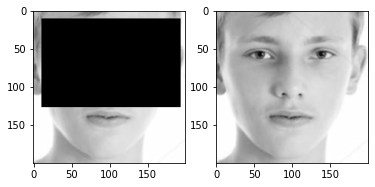

In [ ]:
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[1,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[1,:,:,0],cmap="gray")

In [ ]:
def preprocess_img(image, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image/255., tf.float32)

In [ ]:
data=preprocess_img(x,64)
label=preprocess_img(y,64)

In [ ]:
print("After prerpocessing images:")
print(f"shape of half face labels :{data.shape}")
print(f"shape of half face occluded : {label.shape}")

After prerpocessing images:
shape of half face labels :(4471, 64, 64, 1)
shape of half face occluded : (4471, 64, 64, 1)


## **Mixed precision**

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


```
Why to use mixed precision ❓

using mixed precision we can get our task completed 3x times faster than  modern GPUs and 60% on TPUs.
https://www.tensorflow.org/guide/mixed_precision

```

```
⭐ When using a normal GPU without mixed precision:

* training for 5 epochs takes ~ 6 min.

* with mixed precision it is done ~ 2 min.

```

> **🚥**

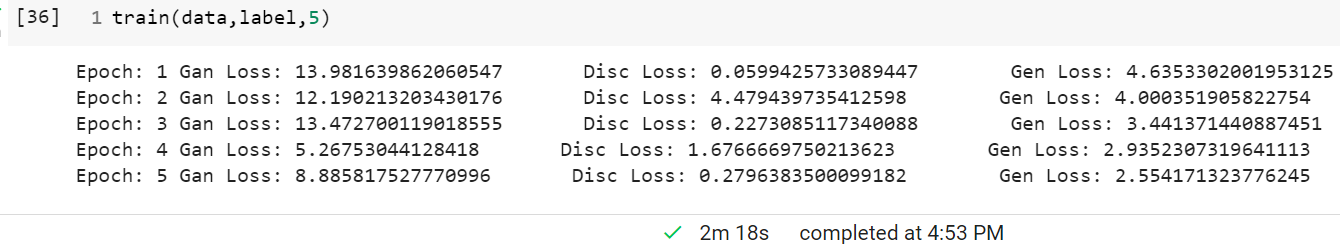

## **Create Model**

```
Cosiderations after experiments:
1. using Batch normalization for stabilize training.
2. using Dropout to avoid overfitting.
3. Avoid max pooling for downsampling. Use convolution stride.
4. Adam optimizer usually works better than other optimizers.
5. Scale the image pixel value between -1 and 1. Use tanh as the output layer for the generator.
6. use LeakyRelu for to avoid sparse gradients.
```
> Refernces :
[1](https://livebook.manning.com/book/gans-in-action/chapter-5/190) 
[2](https://github.com/soumith/ganhacks)
[3](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)

In [ ]:
img_shape=(64,64,1)


### $$\mathbf{Generator\,\,model}$$

In [ ]:
# code for generator
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)       204928    
                                                           


### $$\mathbf{Discriminator\,\,model}$$

In [ ]:
# code for discriminator

discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_17 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       204928    
                                                           

## **Compilation**

**Check layers and thier dtypes and dtype policy**
```
🐾 layers dtype : layers stores information in this type.
🐾 layers dtype policy : layers perform calculation in this type.
```

In [ ]:
for x in generator.layers:
  print(x.name,x.dtype,x.dtype_policy)

input_5 float32 <Policy "float32">
conv2d_14 float32 <Policy "mixed_float16">
batch_normalization_16 float32 <Policy "mixed_float16">
leaky_re_lu_11 float32 <Policy "mixed_float16">
dropout_14 float32 <Policy "mixed_float16">
conv2d_15 float32 <Policy "mixed_float16">
batch_normalization_17 float32 <Policy "mixed_float16">
leaky_re_lu_12 float32 <Policy "mixed_float16">
dropout_15 float32 <Policy "mixed_float16">
conv2d_16 float32 <Policy "mixed_float16">
batch_normalization_18 float32 <Policy "mixed_float16">
leaky_re_lu_13 float32 <Policy "mixed_float16">
dropout_16 float32 <Policy "mixed_float16">
conv2d_transpose_3 float32 <Policy "mixed_float16">
batch_normalization_19 float32 <Policy "mixed_float16">
leaky_re_lu_14 float32 <Policy "mixed_float16">
conv2d_transpose_4 float32 <Policy "mixed_float16">
batch_normalization_20 float32 <Policy "mixed_float16">
leaky_re_lu_15 float32 <Policy "mixed_float16">
conv2d_transpose_5 float32 <Policy "float32">


In [ ]:
for x in discriminator.layers:
  print(x.name,x.dtype,x.dtype_policy)

input_6 float32 <Policy "float32">
conv2d_17 float32 <Policy "mixed_float16">
batch_normalization_21 float32 <Policy "mixed_float16">
leaky_re_lu_16 float32 <Policy "mixed_float16">
dropout_17 float32 <Policy "mixed_float16">
conv2d_18 float32 <Policy "mixed_float16">
batch_normalization_22 float32 <Policy "mixed_float16">
leaky_re_lu_17 float32 <Policy "mixed_float16">
dropout_18 float32 <Policy "mixed_float16">
conv2d_19 float32 <Policy "mixed_float16">
batch_normalization_23 float32 <Policy "mixed_float16">
leaky_re_lu_18 float32 <Policy "mixed_float16">
dropout_19 float32 <Policy "mixed_float16">
conv2d_20 float32 <Policy "mixed_float16">
batch_normalization_24 float32 <Policy "mixed_float16">
leaky_re_lu_19 float32 <Policy "mixed_float16">
dropout_20 float32 <Policy "mixed_float16">
flatten_3 float32 <Policy "mixed_float16">
dense_3 float32 <Policy "float32">


> **Set hyper parametes**

```
Q 1. Why discriminator learning rate is more than generator's learning rate ❓

If Generator and Discriminator both have same learning rate than it will be like ⁉
"A blind person have to guide a blind person"
So Either a Discriminator train earlier so it can have some discriminating nature
or Discriminator have high learning rate than Generator so it can learn faster
than Generator and discriminate between fake and real images so training of
generator will go in right direction.
Generator will get train properly..

Q 2. Why **BCE** and **MSE** ❓ 
look into these articels
```
[1](https://stats.stackexchange.com/questions/242907/why-use-binary-cross-entropy-for-generator-in-adversarial-networks)  [2](https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders)


In [ ]:
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(lr=0.00004))

generator.compile(loss = "mean_squared_error",
                      optimizer = tf.keras.optimizers.Adam(lr=0.00001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



### $$\mathbf{GAN\,\,model}$$

In [ ]:
discriminator.trainable=False

gan=Sequential([
  generator,
  discriminator,
])


gan.compile(loss = "binary_crossentropy",
            optimizer = tf.keras.optimizers.Adam(lr=0.00001))
gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 64, 64, 1)         2054400   
                                                                 
 model_5 (Functional)        (None, 1)                 1438785   
                                                                 
Total params: 3,493,185
Trainable params: 2,053,120
Non-trainable params: 1,440,065
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



##### $$\mathbf{Training\,\,Function}$$

**Standard GAN loss function (min-max GAN loss)**

$$\mathbf{min} \,\, G \,\, \mathbf{max} \,\,D\,\,\, \mathbf{V(D,G)} = E_{x_{ \,\,  ̃  }P_{data}(x)} \,\,log\,D_{θ_{d}}(x) \,\, \mathbf{+} \,\, E_{z { \,\,\,_ ̃   } P(z)} \,\,log (1 - D_{θ_{d}}\,(G_{θ_{g}}(z)))$$

>reference : [1](https://medium.com/analytics-vidhya/understanding-gans-deriving-the-adversarial-loss-from-scratch-ccd8b683d7e2)
[2](https://towardsdatascience.com/the-math-behind-gans-generative-adversarial-networks-3828f3469d9c)

In [ ]:
# Training function


In [ ]:
import numpy as np
np.random.normal(loc=0,size=64)

array([ 0.35988645,  1.36301132,  0.23156339,  0.83325584, -0.36306104,
       -0.1816666 , -1.07263975, -0.77830716, -0.55314108, -0.72732645,
        0.28666999,  0.04438089, -1.11722925, -0.46831777,  0.30803816,
        1.52411784, -0.24072359,  0.30436013, -1.2091677 ,  0.23826835,
        0.98884626,  1.27566872,  1.56788431, -1.11146306,  0.83270448,
        0.8831319 , -0.05931619,  0.85453023, -0.28434114,  0.04260363,
        0.92493073, -1.66884768,  1.27625869,  0.31884669, -0.11643232,
        1.74582352,  2.32305117, -1.33638581, -0.05899278,  1.22414971,
        0.25997429, -0.99901731, -0.76464692, -0.234426  ,  1.45130397,
       -0.56998051, -0.37832206, -0.03790518, -2.26488101, -0.43959257,
        0.07101479,  0.66563436,  0.56439883, -0.54120988,  1.36552456,
       -0.20243779,  0.37067642,  0.27923343,  0.45833033,  1.29901581,
        1.95277731,  0.70391181,  2.43692158,  0.90609885])

## **training**

In [ ]:
print(len(data),len(label))

4471 4471


* train for 250 epochs

In [ ]:
train(data,label,250)

Epoch: 1 Gan Loss: 15.424948692321777       Disc Loss: 0.22947844862937927        Gen Loss: 0.2241610288619995
Epoch: 2 Gan Loss: 4.4394001960754395       Disc Loss: 0.22615490853786469        Gen Loss: 0.16582998633384705
Epoch: 3 Gan Loss: 11.07776165008545       Disc Loss: -0.19493962824344635        Gen Loss: 0.11969040334224701
Epoch: 4 Gan Loss: 5.0527753829956055       Disc Loss: 0.13403281569480896        Gen Loss: 0.08933407068252563
Epoch: 5 Gan Loss: 14.552885055541992       Disc Loss: 0.030760429799556732        Gen Loss: 0.06758876889944077
Epoch: 6 Gan Loss: 3.085127115249634       Disc Loss: 0.1411665678024292        Gen Loss: 0.0534246563911438
Epoch: 7 Gan Loss: 15.211397171020508       Disc Loss: 0.4296594262123108        Gen Loss: 0.04398804157972336
Epoch: 8 Gan Loss: 5.88374662399292       Disc Loss: -0.17771480977535248        Gen Loss: 0.03800912946462631
Epoch: 9 Gan Loss: 14.273153305053711       Disc Loss: -0.26820245385169983        Gen Loss: 0.03386007621884

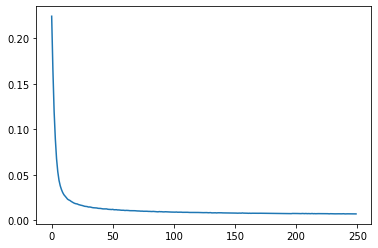

In [ ]:
plt.plot(gen_loss_training)

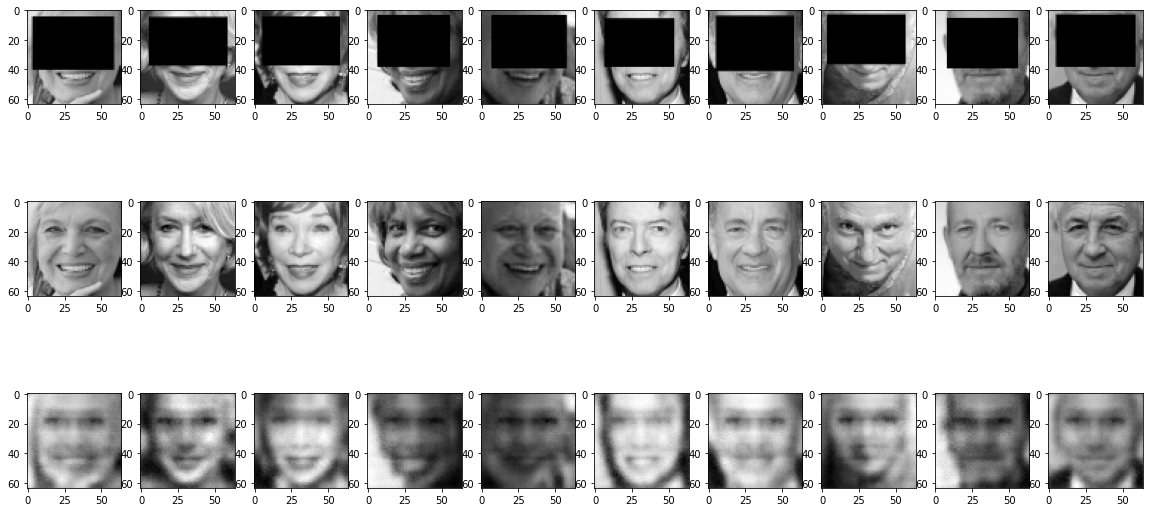

In [ ]:

a = 4160
b = 4170
pred=generator.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  


Text(0.5, 1.0, '250 epochs')

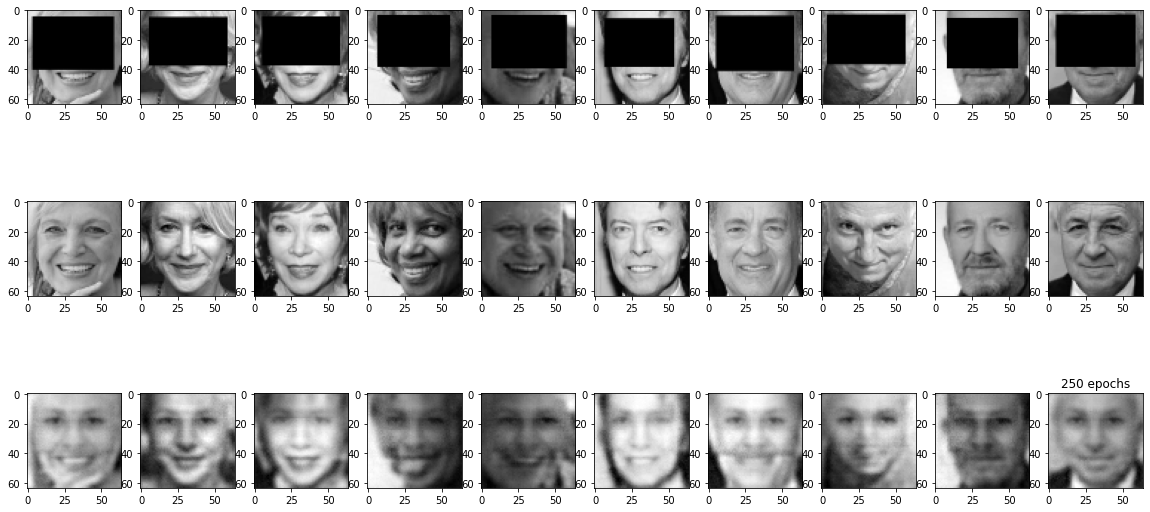

In [ ]:

a = 4160
b = 4170
pred=generator.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
plt.title("250 epochs")

**save model**

In [ ]:
tf.keras.models.save_model(generator,'/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/250-epochs-training_generator_model.h5')

In [ ]:
gen_load_model=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/250-epochs-training_generator_model.h5')

Text(0.5, 1.0, '250 epochs')

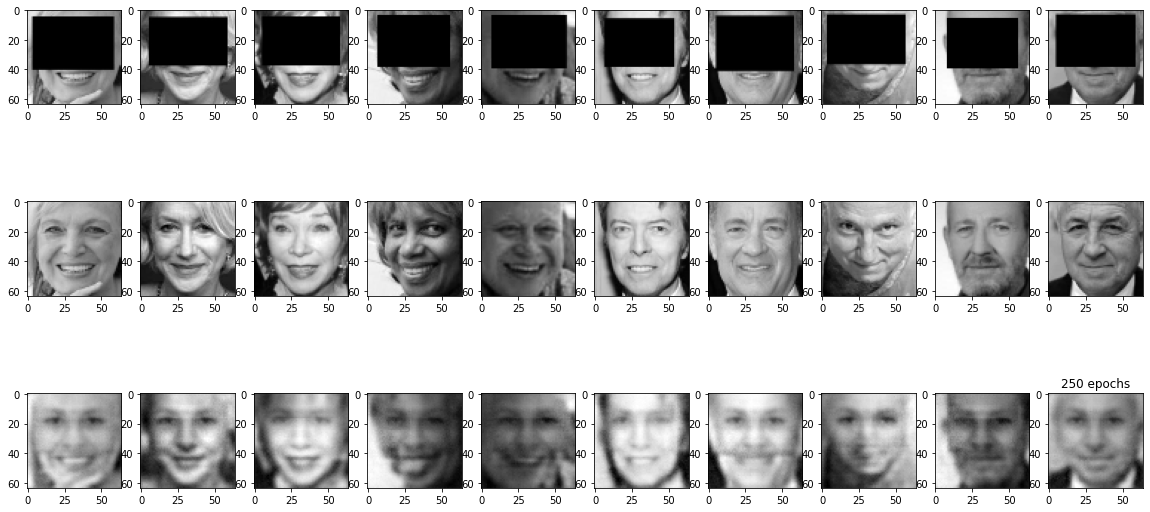

In [ ]:

a = 4160
b = 4170
pred=gen_load_model.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
plt.title("250 epochs")

## **prediction**

In [ ]:
gen_500=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/500_epochs_training_genrator_model.h5')

In [ ]:
gen_250=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/250-epochs-training_generator_model.h5')

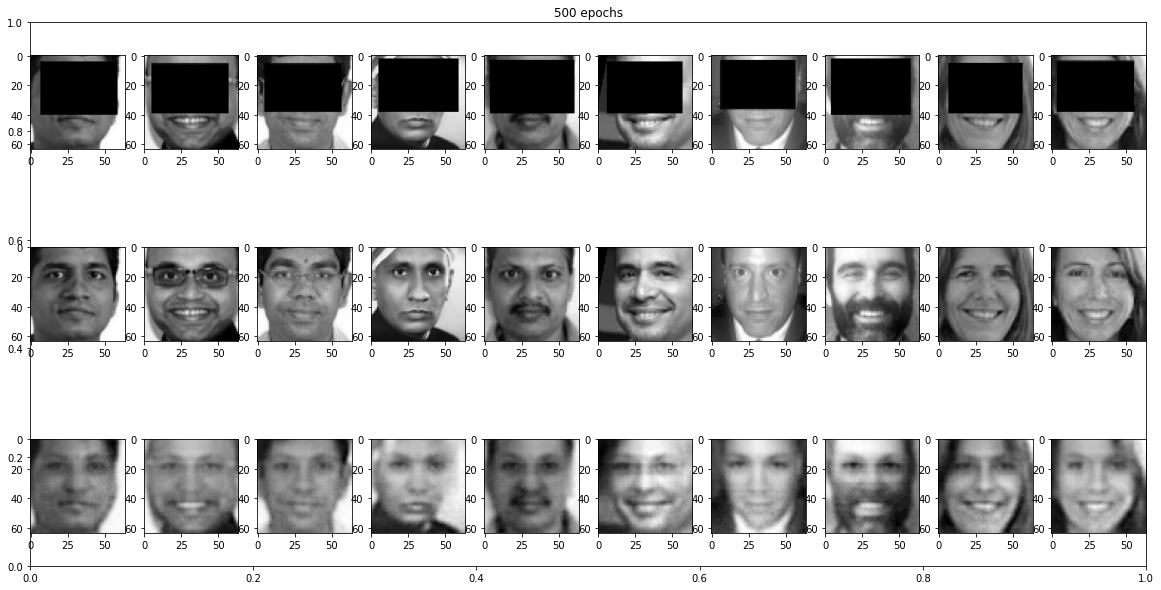

In [ ]:
a = 3160
b = 3170
pred=gen_500.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
plt.title("500 epochs")
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  

for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")

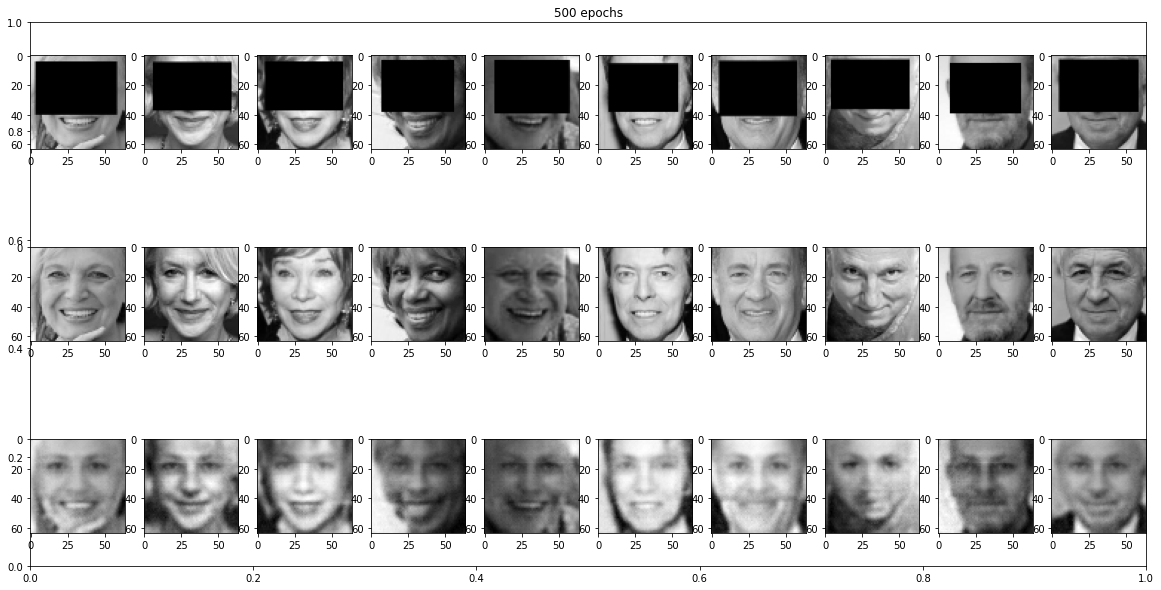

In [ ]:
a = 4160
b = 4170
pred=gen_500.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
plt.title("500 epochs")
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  

for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")

Text(0.5, 1.0, '500 epochs training')

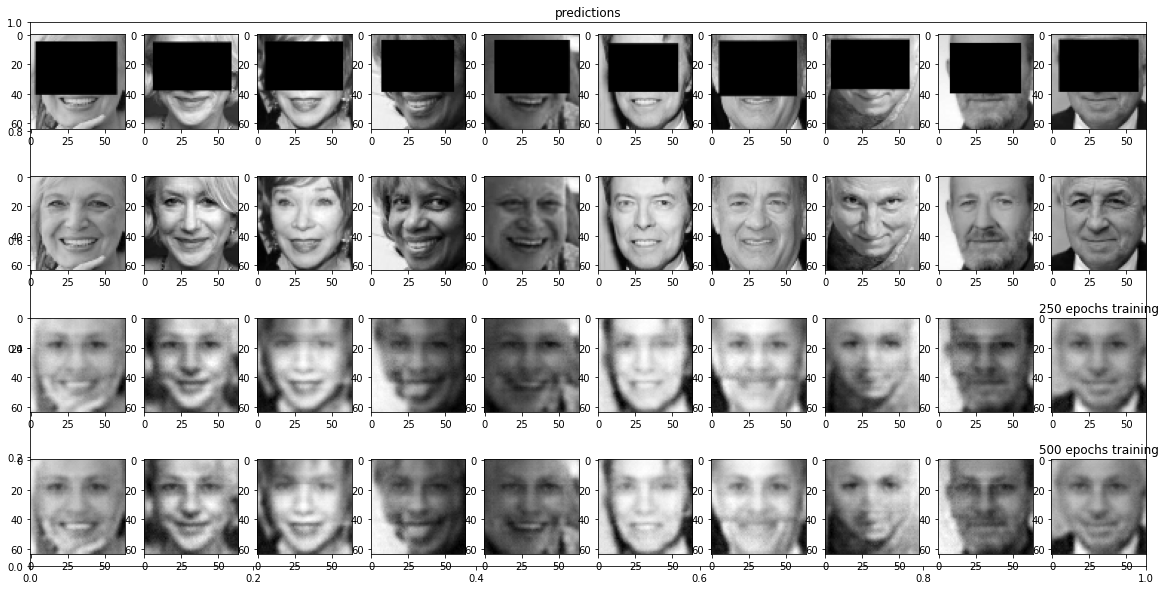

In [ ]:
a = 4160
b = 4170
pred_500=gen_500.predict(data[a:b])
pred_250=gen_250.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
plt.title("predictions")
for ctr in range(10):
  fig.add_subplot(4,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

for ctr in range(10):
  fig.add_subplot(4,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray",label="Original")  

for ctr in range(10):
  fig.add_subplot(4,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred_250[ctr],(64,64)),  cmap = "gray")

plt.title("250 epochs training")
 
for ctr in range(10):
  fig.add_subplot(4,10,(30 + ctr + 1))
  plt.imshow(np.reshape(pred_500[ctr],(64,64)),  cmap = "gray")
plt.title("500 epochs training") 

In [ ]:
gen_100_128_img=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/128_image_size/100_epochs_training_128_images.h5')

In [ ]:
gen_250_128_img=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/128_image_size/250_epochs_training_128_images.h5')

In [ ]:
y_path = '/content/1_half_face_labels.pickle'
x_path = '/content/1_half_face_occluded.pickle'
pickle_in = open(x_path,"rb")
x = pickle.load(pickle_in)  
pickle_in = open(y_path,"rb")
y = pickle.load(pickle_in)

In [ ]:
data=preprocess_img(x,128)
label=preprocess_img(y,128)

Text(0.5, 1.0, '250 epochs training')

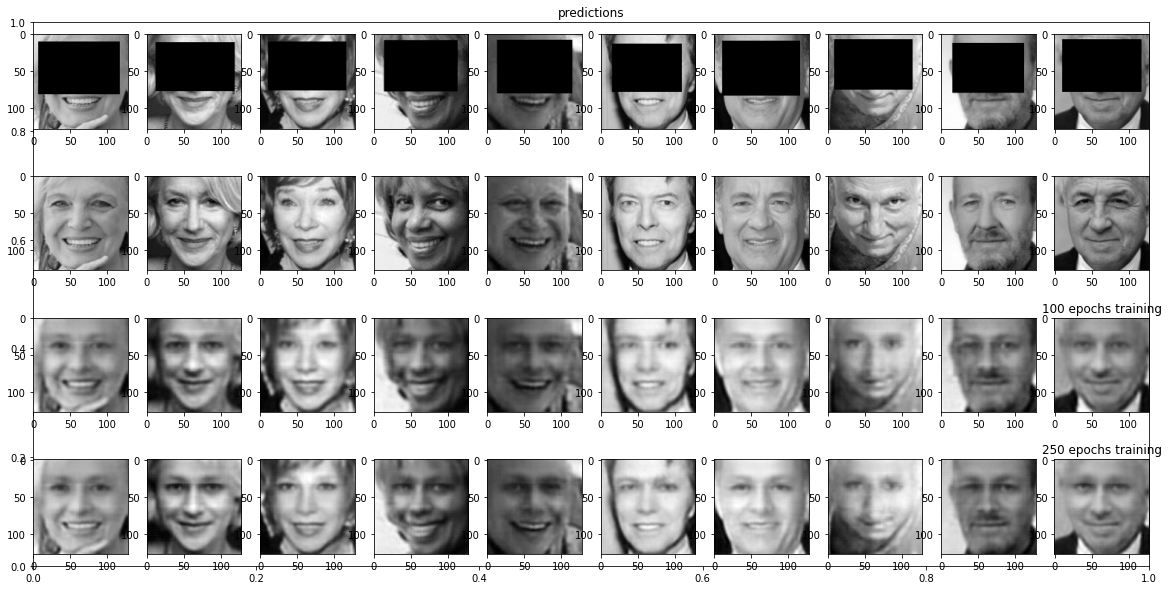

In [ ]:
a = 4160
b = 4170
pred_100=gen_100_128_img.predict(data[a:b])
pred_250=gen_250_128_img.predict(data[a:b])
fig = plt.figure(figsize = (20,10))
plt.title("predictions")
for ctr in range(10):
  fig.add_subplot(4,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(128,128)),  cmap = "gray")
for ctr in range(10):
  fig.add_subplot(4,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(128,128)),  cmap = "gray",label="Original")  
for ctr in range(10):
  fig.add_subplot(4,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred_100[ctr],(128,128)),  cmap = "gray")
plt.title("100 epochs training")
for ctr in range(10):
  fig.add_subplot(4,10,(30 + ctr + 1))
  plt.imshow(np.reshape(pred_250[ctr],(128,128)),  cmap = "gray")
plt.title("250 epochs training") 

**New set of images**

In [ ]:
y_path = '/content/unres_labels.pickle'
x_path = '/content/unres_occluded.pickle'

pickle_in = open(x_path,"rb")
x = pickle.load(pickle_in)  

pickle_in = open(y_path,"rb")
y = pickle.load(pickle_in)

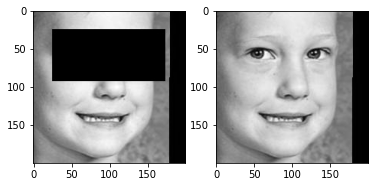

In [ ]:
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[1,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[1,:,:,0],cmap="gray")

## **Evaluation**

In [ ]:
# laod save model
gen_500=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PROJECT/models/all_models/500_epochs_training_genrator_model.h5')

Text(0.5, 1.0, '500 epochs')

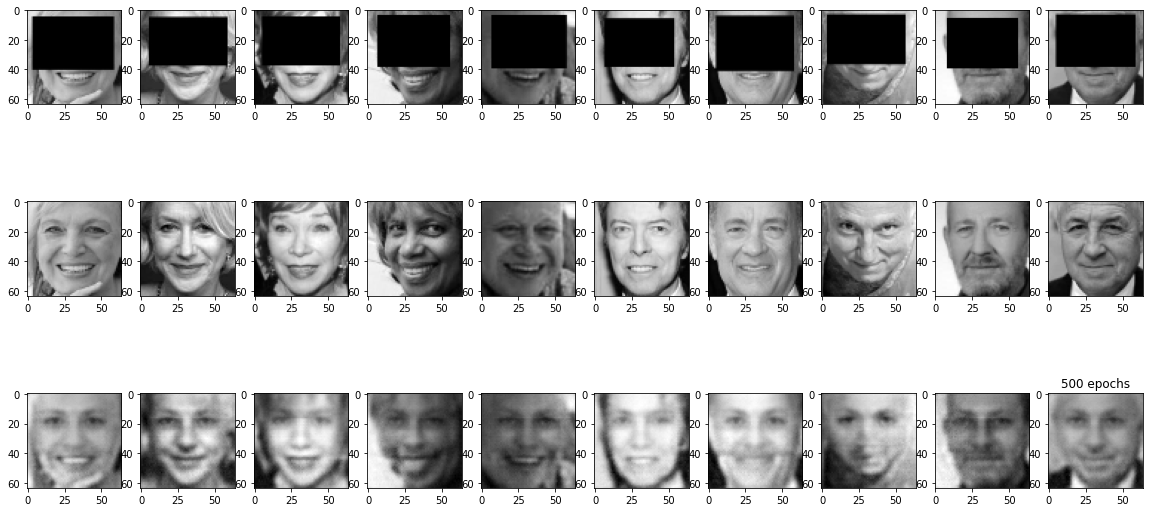

In [ ]:
a = 4160
b = 4170
pred=gen_500.predict(data[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(data[a + ctr],(64,64)),  cmap = "gray")

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(label[a + ctr]/255,(64,64)),  cmap = "gray")  

for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
plt.title("500 epochs")

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

In [ ]:
# calculate frechet inception distance
def calculate_fid(act1, act2):

	# calculate mean and covariance statistics
	mean1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mean2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mean1 - mean2)**2.0)
 
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
 
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
fid_scores=[]
for i in range(10):
  fid_scores.append(calculate_fid(label[a+i,:,:,0].numpy(),np.reshape(pred[i],(64,64))))

In [ ]:
fid=(1-tf.reduce_mean(fid_scores))*100

print(f"Generated images are {int(numpy.ceil(fid))}% same as Original image")

Generated images are 82% same as Original image
